# Preparing an AF state in the Ising model

The purpose of this notebook is to illustrate how to build a sequence for preparing an AF state in the Ising model. 

(This notebook is supposed to evolve with code updates.) 

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Pulse, Sequence, Register
from pulser.waveforms import ConstantWaveform, RampWaveform
from pulser.devices import Chadoq2, Mock
from pulser.simulation import Simulation

# 1. 2D Square Array

## Waveforms 

We are realizing the following program

<img src="files/AF_Ising_program.png" alt="AF Pulse Sequence" style="width: 320px;"/>

In [50]:
# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -6 * 2*np.pi
delta_f = 2 * 2*np.pi
Omega_max = 2.3 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 250
t_fall = 500
t_sweep = (delta_f-delta_0)/(2*np.pi*10) * 1000

Blockade Radius is: 8.380940729382289µm.


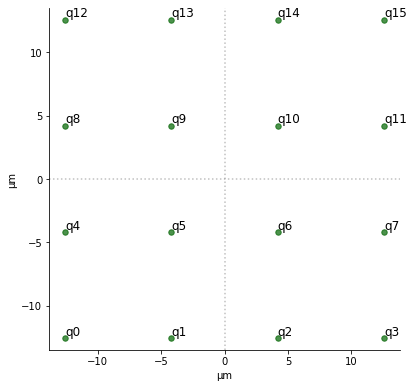

In [67]:
R_blockade = (5.008e6/Omega_max)**(1/6)
reg = Register.rectangle(4,4, spacing=R_blockade, prefix='q')
print(f'Blockade Radius is: {R_blockade}µm.')
reg.draw()

In [68]:
rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

## Creating my sequence

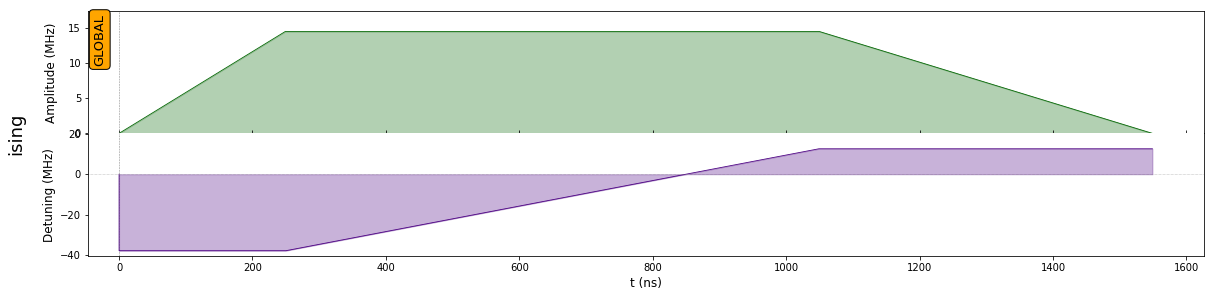

In [69]:
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

#print(seq)
seq.draw()

## Phase Diagram

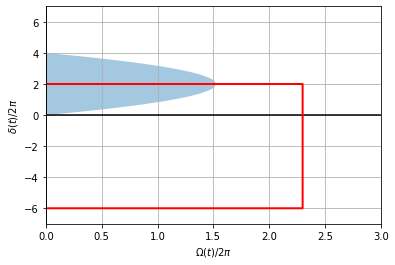

In [70]:
#phase = {'omega':[], 'delta':[], 'time': range(max(seq._last(ch).tf for ch in seq.declared_channels))}
delta = []
omega = []
for x in seq._schedule['ising']:
    if isinstance(x.type,Pulse):
        omega += list(x.type.amplitude.samples)
        delta += list(x.type.detuning.samples)
        
fig, ax = plt.subplots()
ax.grid(True, which='both')

ax.set_ylabel(r"$\delta(t)/2\pi$")
ax.set_xlabel(r"$\Omega(t)/2\pi$")
ax.set_xlim(0,3)
ax.set_ylim(-7,7)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

y = np.arange(0.0, 6, 0.01)
x = 1.522*(1-0.25*(y-2)**2)
ax.fill_between(x, y, alpha=0.4)

ax.plot(np.array(omega)/(2*np.pi),np.array(delta)/(2*np.pi),'red',lw=2)


# Simulation

In [71]:
simul = Simulation(seq)

In [72]:
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

By parity symmetry, we only need to observe half of the atoms, the other one reflects the results

In [73]:
simul.run(obs_list=occup_list, progress_bar=True)

Observables provided. Calculating expectation value...
10.0%. Run time:   8.83s. Est. time left: 00:00:01:19
20.0%. Run time:  17.51s. Est. time left: 00:00:01:10
30.0%. Run time:  26.75s. Est. time left: 00:00:01:02
40.0%. Run time:  36.46s. Est. time left: 00:00:00:54
50.0%. Run time:  48.71s. Est. time left: 00:00:00:48
60.0%. Run time:  62.35s. Est. time left: 00:00:00:41
70.0%. Run time:  77.71s. Est. time left: 00:00:00:33
80.0%. Run time:  93.73s. Est. time left: 00:00:00:23
90.0%. Run time: 108.06s. Est. time left: 00:00:00:12
Total run time: 121.52s


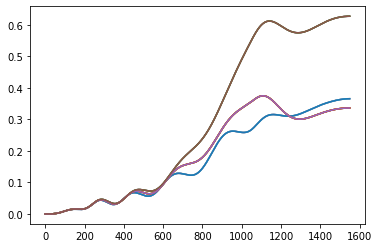

In [74]:
for expv in simul.output.expect:
    plt.plot(expv)

[[0.62774283 0.33639599 0.33639599 0.62774283]
 [0.33639599 0.36586338 0.36586338 0.33639599]
 [0.33639599 0.36586338 0.36586338 0.33639599]
 [0.62774283 0.33639599 0.33639599 0.62774283]]


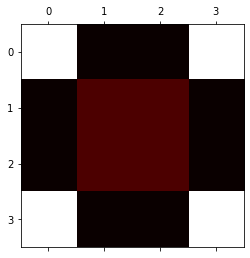

In [75]:
L = int(np.sqrt(len(reg.qubits)))
res=np.zeros((L,L))
for i,ev in enumerate(simul.output.expect):
    res[i//L,i%L] = ev[-1]
plt.matshow(res, cmap='hot')
print(res)

# 2. 1D Periodic Chain

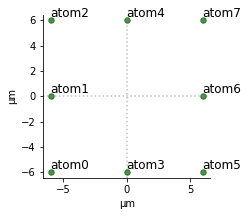

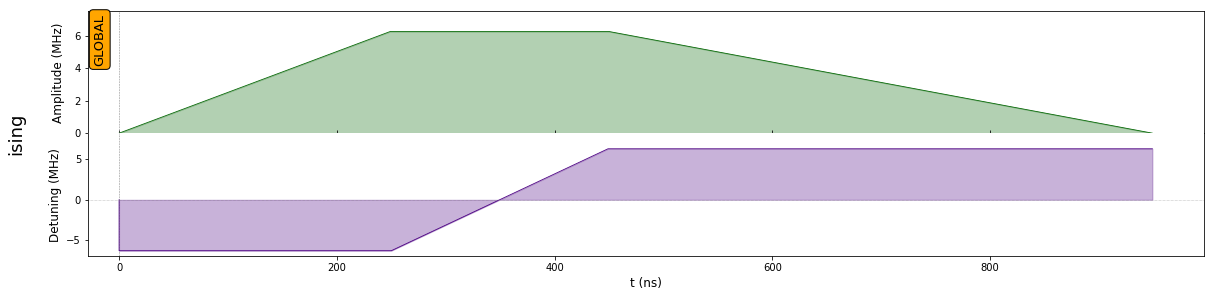

In [12]:
n_side = 3
coords = 6 * np.array([(x,y) for x in range(n_side) for y in range(n_side) 
                    if (x in {0,n_side-1} or y in {0,n_side-1})], dtype=np.float64)
reg = Register.from_coordinates(coords, prefix='atom')
reg.draw()

# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -1 * 2*np.pi
delta_f = 1 * 2*np.pi
Omega_max = 1 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 250
t_fall = 500
t_sweep = (delta_f-delta_0)/(2*np.pi*10) * 1000

rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')

#print(seq)
seq.draw()

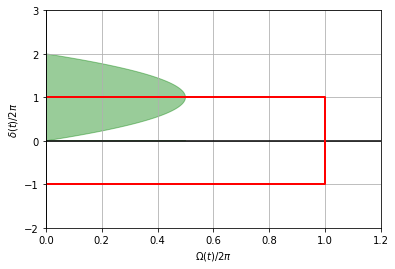

In [13]:
#phase = {'omega':[], 'delta':[], 'time': range(max(seq._last(ch).tf for ch in seq.declared_channels))}
delta = []
omega = []
for x in seq._schedule['ising']:
    if isinstance(x.type,Pulse):
        omega += list(x.type.amplitude.samples)
        delta += list(x.type.detuning.samples)
        
fig, ax = plt.subplots()
ax.grid(True, which='both')

ax.set_ylabel(r"$\delta(t)/2\pi$")
ax.set_xlabel(r"$\Omega(t)/2\pi$")
ax.set_xlim(0,1.2)
ax.set_ylim(-2,3)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

y = np.arange(0.0, 6, 0.01)
x = 0.5*(1-(y-1)**2)
ax.fill_between(x, y, color='green',alpha=0.4)

ax.plot(np.array(omega)/(2*np.pi),np.array(delta)/(2*np.pi),'red',lw=2)

In [14]:
simul = Simulation(seq)

up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

simul.run(obs_list=occup_list, progress_bar=True)

Observables provided. Calculating expectation value...
10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.06s. Est. time left: 00:00:00:00
30.0%. Run time:   0.09s. Est. time left: 00:00:00:00
40.0%. Run time:   0.11s. Est. time left: 00:00:00:00
50.0%. Run time:   0.14s. Est. time left: 00:00:00:00
60.0%. Run time:   0.18s. Est. time left: 00:00:00:00
70.0%. Run time:   0.21s. Est. time left: 00:00:00:00
80.0%. Run time:   0.23s. Est. time left: 00:00:00:00
90.0%. Run time:   0.26s. Est. time left: 00:00:00:00
Total run time:   0.29s


[[0.61731519 0.11988636 0.61731519]
 [0.11988636 0.         0.11988636]
 [0.61731519 0.11988636 0.61731519]]


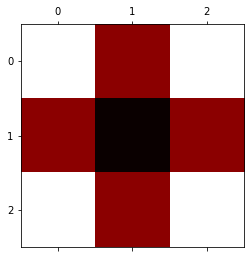

In [15]:
#Plot
L = n_side
res = np.zeros((L,L))
pos = [k for k in range(L*L) if (k//L in {0,L-1} or k%L in {0,L-1})] # valid position indexes in atom array
for i,ev in enumerate(simul.output.expect):
    x = pos[i]//L
    y = pos[i]%L
    res[x,y] = ev[-1]
plt.matshow(res, cmap='hot')
print(res)

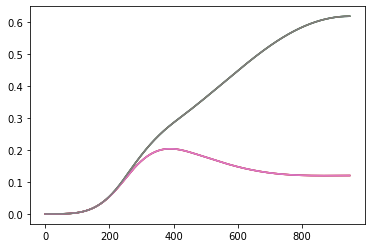

In [16]:
for expv in simul.output.expect:
    plt.plot(expv)